# Recommender Systems using Latent-Factor Models
In this post, I describe an implementation of a [recommender system](!https://en.wikipedia.org/wiki/Recommender_system) based on latent-factor models and its application to the [MovieLens 100K Dataset](!http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html). The system is built within the Scikit-Learn framework to allow for using Scikit-Learn features such as [Pipelines](!http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [GridSearchCV](!http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). 

### Import the relevant libraries

In [2]:
import collections
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import pickle
from time import time
import requests
import urllib
from IPython.display import Image, display
from IPython.core.display import HTML 
import re

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='white', palette='Set2')

In [3]:
np.set_printoptions(precision=2, suppress=True)
np.random.seed(seed=0)

## Load the data
Download the MovieLens 100K Dataset. This a classic dataset which is often used to test the performance of recommender systems. We will use files 'movies.csv' and 'ratings.csv' from this dataset.

In [4]:
"""!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
!mv ml-latest-small/ ml-100k"""

'!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip\n!unzip ml-latest-small.zip\n!mv ml-latest-small/ ml-100k'

In [5]:
# Read in the data into pandas dataframes
df_movies = pd.read_csv('ml-100k/movies.csv')
df_ratings = pd.read_csv('ml-100k/ratings.csv')
df_ratings.columns = ['userId', 'itemId', 'rating', 'timestamp']
df_ratings['timestamp'] = df_ratings['timestamp'].astype(str)
print (df_movies.head(2))
print (df_ratings.head(2))

   movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1        2    Jumanji (1995)                   Adventure|Children|Fantasy
   userId  itemId  rating   timestamp
0       1      31     2.5  1260759144
1       1    1029     3.0  1260759179


### Split the dataset into train (80%) and test (20%) datasets.

First let's explore the distribution of the number of movies versus number of ratings. From the following histogram, we see that many movies are rated only by less than 10 users.

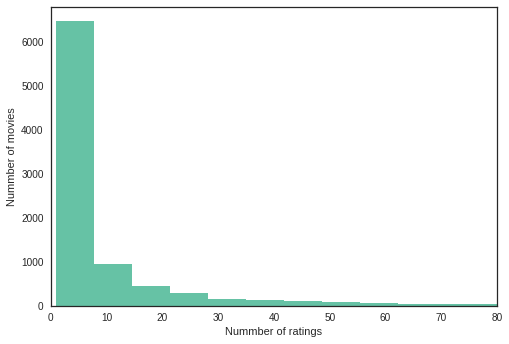

In [14]:
plt.hist(df_ratings.groupby(['itemId'])['userId']
                   .count().values, bins=50);
plt.xlim(0,80)
plt.xlabel('Nummber of ratings')
plt.ylabel('Nummber of movies')

We partition our dataset into train and test sets by removing 10 randomly selected movies rated by each user from the original dataset and placing them in the test set. The remaining dataset is our train set. 

The following function can be used to partition our dataset into train and test sets. We will use it later in this post.

In [15]:
def train_test_split_df(df, test_size=10):
    def drop_rows(df, remove_n):#, itemIds_single_rating):
        drop_indices = np.random.choice(df.index, remove_n, replace=False)
        #drop_indices = [i for i in drop_indices if i not in itemIds_single_rating]
        return df.drop(drop_indices)

    # ItemIds' occuring more than 20 times
    counts = collections.Counter(df['itemId'])
    #itemIds_single_rating = [k for k,v in counts.items() if v<2]

    grouped = df.groupby(by=['userId'], group_keys=False)
    remove_n = test_size
    df_train = df.groupby(['userId']).apply(
                    lambda x: drop_rows(x, remove_n))#, 
                                        #itemIds_single_rating))
    df_train = df_train.reset_index(level=0, drop=True)
    df_test = df[~df.index.isin(df_train.index)]
    
    removed_item_ids = set(df['itemId']) - set(df_train['itemId'])
    dummy_ratings = []
    dummy_userIds = np.random.choice(df['userId'].unique(), 
                                 size=len(removed_item_ids))
    for i,itemid in enumerate(removed_item_ids):
        dummy_ratings.append([dummy_userIds[i],itemid,0.001,'NaN'])
    
    df_train_dummy = pd.DataFrame(dummy_ratings, columns=['userId', 'itemId', 'rating', 'timestamp'])
    df_train = pd.concat([df_train, df_train_dummy])
    
    return df_train, df_test


"""#df_train, df_test = train_test_split_df(df_ratings.iloc[:1000], test_size=10)
df_train, df_test = train_test_split_df(df_ratings, test_size=10)
print (len(df_train), len(df_test), len(df_ratings))"""

"""ratings_extractor = RatingsExtractor()
ratings_extractor.transform(df_train)

ratings_extractor = RatingsExtractor()
ratings_extractor.transform(df_ratings)"""

93423 6710 100004


'ratings_extractor = RatingsExtractor()\nratings_extractor.transform(df_train)\n\nratings_extractor = RatingsExtractor()\nratings_extractor.transform(df_ratings)'

## Transformer
The following transformer (called RatingsExtractor) converts a pandas dataframe containing itemIds, userIds, and ratings into an $m \times n$ sparse matrix, where $m$ is the number of items and $n$ is the number of users. It also implements dictionaries to convert the row and column indices into item and user ids and vice versa.

In [7]:
class RatingsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.index2user_dict = {}
        self.index2item_dict = {}
        self.user2index_dict = {}
        self.item2index_dict = {}
        self.ratings = csr_matrix([], dtype=np.float)

    def fit(self,df_ratings):
        return self
    
    def transform(self, df_ratings):
        for i,uid in enumerate(sorted(df_ratings['userId'].unique())):
            self.index2user_dict[i] = uid
        for i,mid in enumerate(sorted(df_ratings['itemId'].unique())):
            self.index2item_dict[i] = mid
            
        self.user2index_dict = {v:k for k,v in self.index2user_dict.items()}
        self.item2index_dict = {v:k for k,v in self.index2item_dict.items()}

        n_items = len(self.index2item_dict)
        n_users = len(self.index2user_dict)
        row_ind = [self.item2index_dict[mov]  
                   for mov in df_ratings['itemId'].values]
        col_ind = [self.user2index_dict[mov] 
                   for mov in df_ratings['userId'].values]
        data = df_ratings['rating'].values

        self.ratings = csr_matrix((data, (row_ind, col_ind)), shape=(n_items, n_users))
        return self.ratings
    
    def get_row_col_indices(self, df_test):
        row_indices = [self.item2index_dict[k] 
                       for k in df_test['itemId'].values]
        col_indices = [self.user2index_dict[k] 
                       for k in df_test['userId'].values]
        return list(zip(row_indices,col_indices))


"""ratings_extractor = RatingsExtractor()
ratings = ratings_extractor.transform(df_ratings)"""

'ratings_extractor = RatingsExtractor()\nratings = ratings_extractor.transform(df_ratings)'

## Estimator
Our estimator implements the intuition shown in the figure below.

![](img/rec_sys_matrices.png)


So our predicted rating for item-user pair ($i,x$) is given by:
\begin{align}
\hat{r}_{ix} = \mu + b_i + b_x + \mathbf{q_i} \cdot \mathbf{p_x} \\
\end{align}

where,

$\mu$ is the global mean rating,

$b_i$ is the item bias for item $i$,

$b_x$ is the user bias for user $x$,

$\mathbf{q_i}$ is the latent factor vector for item $i$, and

$\mathbf{p_x}$ is the latent factor vector for user $x$.

The objective function can be written as
\begin{align}
J = 
 \sum_{(i,x) \in R} \left( r_{i,x} - \left( \mu + 
                      b_i + b_x + 
                      \mathbf{q_i} \cdot \mathbf{p_x} \right) \right)^2  
                   + \lambda_{if} \sum_i \left\lVert q_i \right\rVert ^2  
                   + \lambda_{xf} \sum_x \left\lVert p_x \right\rVert ^2 \\  
                   + \lambda_{ib} \sum_i b_i^2 + 
                   \lambda_{xb} \sum_x b_x^2 
\end{align}

Here, $\lambda_{if}, \lambda_{xf}, \lambda_{ib}, \lambda_{xb}$ are regularization parameters. I used Stochastic Gradient Descent (SGD) algorithm to minimize the objective function $J$. Alternatively, one can also use Alternating Least Squares (ALS) algorithm.

In the SGD algorithm, we update each parameter ($b_x$, $b_i$, $q_i$, and $p_x$) with each sample using gradient update of the form

\begin{align}
\theta := \theta - \eta \frac{\partial J}{\partial \theta}
\end{align}.

Our SGD parameter updates become
\begin{align}
b_i := b_i + \eta \left( e_{ix} - \lambda{ib} b_i \right) \\
b_x := b_x + \eta \left( e_{ix} - \lambda_{xb} b_x \right) \\
\mathbf{q_i} := \mathbf{q_i} + \eta \left( e_{ix} \mathbf{p_x} - \lambda_{if} \mathbf{q_i} \right) \\
\mathbf{p_x} := \mathbf{p_x} + \eta \left( e_{ix} \mathbf{q_i} - \lambda_{xf} \mathbf{p_x} \right)
\end{align}

where, $e_{ix} = r_{ix} - \hat{r}_{ix}$ is the prediction error.

The above algorithm is implemented in LatentFactorRecSys class below.

In [8]:
class LatentFactorRecSys(BaseEstimator, TransformerMixin):
    def __init__(self, reg_item_fact=0.1, reg_user_fact=0.1, 
                 reg_item_bias=0.1, reg_user_bias=0.1,
                 num_factors=20,
                 learning_rate=0.001, max_iter=10,
                 tolerance=0.1):
        self.reg_item_fact = reg_item_fact
        self.reg_user_fact = reg_user_fact
        self.reg_item_bias = reg_item_bias
        self.reg_user_bias = reg_user_bias
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tolerance = tolerance
        
        """self.R = csr_matrix([], dtype=np.float)
        self.mu = 0.0
        self.bx = csr_matrix([], dtype=np.float)
        self.bi = csr_matrix([], dtype=np.float)
        self.P = csr_matrix([], dtype=np.float)
        self.Q = csr_matrix([], dtype=np.float)
        self.rmse_iter = []"""
        
 
    def fit(self,ratings,y=None):
        self.R = ratings

        f = self.num_factors
        eta = self.learning_rate
        lambda_if = self.reg_item_fact
        lambda_xf = self.reg_user_fact
        lambda_ib = self.reg_item_bias
        lambda_xb = self.reg_user_bias
            
        #nonzero_indices = list(zip(self.R.nonzero()[0].tolist(),
        #                           self.R.nonzero()[1].tolist()))
        nonzero_indices = list(zip(*ratings.nonzero()))
        n_items,n_users = self.R.shape 
        
        self.P = np.random.uniform(0,np.sqrt(self.R.max()/f),
                                   size=(n_users,f)) # User factors
        self.Q = np.random.uniform(0,np.sqrt(self.R.max()/f),
                                   size=(n_items,f)) # Item factors
        self.bx = np.random.uniform(-1,1,n_users) # User bias
        self.bi = np.random.uniform(-1,1,n_items) # Item bias
        self.mu = self.R.sum()/self.R.size # Overall mean rating
        
        self.rmse_iter = []
        for it in range(self.max_iter):    
            for i,x in nonzero_indices:
                res_ix = self.R[i,x] - self.predict_ix(i,x)
                self.bx[x]  += eta*(res_ix - lambda_xb*self.bx[x])
                self.bi[i]  += eta*(res_ix - lambda_ib*self.bi[i])
                ptemp = self.P[x,:]
                self.P[x,:] += eta*(res_ix*self.Q[i,:] - 
                                    lambda_xf*self.P[x,:])
                self.Q[i,:] += eta*(res_ix*ptemp - 
                                    lambda_if*self.Q[i,:])        
        
            cur_rmse = self.rmse_all()
            self.rmse_iter.append((it,cur_rmse))
            if (it>0 and self.rmse_iter[it-1][1]-cur_rmse < self.tolerance):
                print ('converged at iter = %d, rmse = %f' % (it+1, cur_rmse))
                return self
            
        print ('not converged, number of iterations exceeded max_iter = %d ' % self.max_iter)
        print ('current rmse = %f' % cur_rmse)
        return self
    
    
    def transform(self,ratings,y=None):
        return self
    
    def predict_ix(self,item_index,user_index):
        return (self.mu + self.bx[user_index] + self.bi[item_index] + 
                np.dot(self.P[user_index,:],self.Q[item_index,:]))
    
    def predict(self,itemid_userid_array,ratings_extractor):
        pred = []
        for itemid,userid in itemid_userid_array:
            item_index = ratings_extractor.item2index_dict[itemid]
            user_index = ratings_extractor.user2index_dict[userid]
            #print (itemid,userid,item_index,user_index)
            pred.append(self.predict_ix(item_index,user_index))
        return pred
    
        
    def predict_all(self):
        n_items, n_users = self.R.shape

        #nonzero_indices = list(zip(self.R.nonzero()[0].tolist(),
        #                           self.R.nonzero()[1].tolist()))
        nonzero_indices = list(zip(*self.R.nonzero()))
        row_ind = [i for i,x in nonzero_indices]
        col_ind = [x for i,x in nonzero_indices]
        mask = csr_matrix(([1.]*self.R.size, (row_ind, col_ind)), 
                          shape=(n_items, n_users))
        
        biases = (self.mu*mask 
                  + mask.multiply(np.tile(self.bx,(n_items,1))) 
                  + mask.multiply(np.tile(self.bi[np.newaxis].transpose(),
                                        (1,n_users))))
        predictions = biases + mask.multiply(np.matmul(self.Q,self.P.T)) # elementwise multiplication
        return predictions
        
        
    def rmse_all(self):
        Residue = self.R - self.predict_all() 
        return np.sqrt(Residue.multiply(Residue).sum()/self.R.size)
        
    def score(self,ratings,y=None):
        # rec.named_steps['lf_recommender'].R.data                
        return r2_score(self.R.data, self.predict_all().data)
    
    def get_convergence_curve(self):
        return self.rmse_iter
    
    
"""rec = LatentFactorRecSys(max_iter=2)
# print (rec.get_params())
# rec.set_params(max_iter=10)

rec.fit(ratings)

conv_curve = rec.get_convergence_curve()
iter_index,rmse = tuple(zip(*conv_curve))

plt.plot(iter_index,rmse, '-ok')
plt.xlabel('iteration')
plt.ylabel('RMSE')"""

"rec = LatentFactorRecSys(max_iter=2)\n# print (rec.get_params())\n# rec.set_params(max_iter=10)\n\nrec.fit(ratings)\n\nconv_curve = rec.get_convergence_curve()\niter_index,rmse = tuple(zip(*conv_curve))\n\nplt.plot(iter_index,rmse, '-ok')\nplt.xlabel('iteration')\nplt.ylabel('RMSE')"

## Pipeline
We combine our RatingsExtractor and LatentFactorRecSys classes in a scikit-learn pipeline.

In [9]:
rec_pipeline = Pipeline(
    [('ratings_extractor', RatingsExtractor()),     
     ('lf_recommender', LatentFactorRecSys(max_iter=10, tolerance=0.01))
    ])

"""num_samples = 1000
rec_pipeline.fit(df_ratings.sample(num_samples, random_state=0))
print (rec_pipeline)

conv_curve = rec_pipeline.named_steps['lf_recommender'].get_convergence_curve()
iter_index,rmse = tuple(zip(*conv_curve))

plt.plot(iter_index,rmse, '-ok')
plt.xlabel('iteration')
plt.ylabel('RMSE')"""

"num_samples = 1000\nrec_pipeline.fit(df_ratings.sample(num_samples, random_state=0))\nprint (rec_pipeline)\n\nconv_curve = rec_pipeline.named_steps['lf_recommender'].get_convergence_curve()\niter_index,rmse = tuple(zip(*conv_curve))\n\nplt.plot(iter_index,rmse, '-ok')\nplt.xlabel('iteration')\nplt.ylabel('RMSE')"

## GridSearch
Next, we perform a gridsearch over our model parameters $f$ (number of latent factors), $\lambda_{if}, \lambda_{xf}, \lambda_{ib}, \lambda_{xb}$  and the hyperparameter $\eta$ (learning rate). 

In the following grid search, I have used only 1,000 samples and $max\_iter = 30$. In addition, all the reguralization coefficients are set to the same value to limit the search space. This is done to keep the computations tractable.

In [11]:
"""num_latent_factors = [10] #[10, 20]
regularizations = [0.1] #[0.1, 1.0]
learning_rates = [0.01] #[0.01, 0.1]
iterations = [2] #[25, 50, 75, 100]"""

num_latent_factors = [40, 60, 80, 100]
regularizations = [0.001, 0.01, 0.1, 1.0]
learning_rates = [0.0001, 0.001, 0.01]
iterations = [30]

grid= []
for reg in regularizations:
    grid.append({'lf_recommender__num_factors': num_latent_factors,
                 'lf_recommender__learning_rate': learning_rates,
                 'lf_recommender__max_iter': iterations,
                 'lf_recommender__reg_item_bias': [reg],
                 'lf_recommender__reg_item_fact': [reg],
                 'lf_recommender__reg_user_bias': [reg],
                 'lf_recommender__reg_user_fact': [reg],
                })
    
#print (list(ParameterGrid(grid)))

grid_search = GridSearchCV(rec_pipeline, param_grid=grid, 
                           cv=2, verbose=0, n_jobs=3)
print (grid_search)

num_samples = 1000
grid_search.fit(df_ratings.sample(num_samples, random_state=0))

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(steps=[('ratings_extractor', RatingsExtractor()), ('lf_recommender', LatentFactorRecSys(learning_rate=0.001, max_iter=10, num_factors=20,
          reg_item_bias=0.1, reg_item_fact=0.1, reg_user_bias=0.1,
          reg_user_fact=0.1, tolerance=0.01))]),
       fit_params={}, iid=True, n_jobs=3,
       param_grid=[{'lf_recommender__num_factors': [40, 60, 80, 100], 'lf_recommender__learning_rate': [0.0001, 0.001, 0.01], 'lf_recommender__max_iter': [30], 'lf_recommender__reg_item_bias': [0.001], 'lf_recommender__reg_item_fact': [0.001], 'lf_recommender__reg_user_bias': [0.001], 'lf_recommender__reg_..._item_fact': [1.0], 'lf_recommender__reg_user_bias': [1.0], 'lf_recommender__reg_user_fact': [1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
converged at iter = 2, rmse = 1.777826
converged at iter = 2, rmse = 1.828849
converged at iter = 2, rmse = 1.820899
converge

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(steps=[('ratings_extractor', RatingsExtractor()), ('lf_recommender', LatentFactorRecSys(learning_rate=0.001, max_iter=10, num_factors=20,
          reg_item_bias=0.1, reg_item_fact=0.1, reg_user_bias=0.1,
          reg_user_fact=0.1, tolerance=0.01))]),
       fit_params={}, iid=True, n_jobs=3,
       param_grid=[{'lf_recommender__num_factors': [40, 60, 80, 100], 'lf_recommender__learning_rate': [0.0001, 0.001, 0.01], 'lf_recommender__max_iter': [30], 'lf_recommender__reg_item_bias': [0.001], 'lf_recommender__reg_item_fact': [0.001], 'lf_recommender__reg_user_bias': [0.001], 'lf_recommender__reg_..._item_fact': [1.0], 'lf_recommender__reg_user_bias': [1.0], 'lf_recommender__reg_user_fact': [1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [12]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.18,  0.25,  0.29,  0.3 ,  3.88,  4.25,  3.7 ,  4.09,  4.3 ,
         4.02,  4.03,  4.04,  0.3 ,  0.28,  0.3 ,  0.23,  3.99,  3.71,
         3.81,  3.87,  3.84,  4.04,  4.54,  4.55,  0.24,  0.33,  0.35,
         0.36,  4.02,  3.27,  4.11,  3.54,  3.61,  3.92,  4.  ,  4.12,
         0.31,  0.32,  0.29,  0.32,  4.1 ,  4.01,  3.93,  4.07,  3.1 ,
         3.1 ,  2.96,  2.54]),
 'mean_score_time': array([ 0.01,  0.01,  0.01,  0.01,  0.02,  0.01,  0.01,  0.01,  0.02,
         0.01,  0.02,  0.01,  0.02,  0.02,  0.01,  0.01,  0.03,  0.01,
         0.01,  0.04,  0.02,  0.01,  0.02,  0.02,  0.01,  0.03,  0.02,
         0.03,  0.01,  0.01,  0.02,  0.02,  0.02,  0.01,  0.02,  0.02,
         0.02,  0.01,  0.02,  0.01,  0.01,  0.02,  0.01,  0.01,  0.01,
         0.01,  0.03,  0.02]),
 'mean_test_score': array([-1.76, -1.91, -1.91, -2.06, -0.84, -0.95, -0.87, -0.74,  0.83,
         0.83,  0.83,  0.83, -1.87, -1.91, -1.84, -2.01, -0.87, -0.85,
        -0.78, -0.81,  0.83,  0

## Retrain optimal model on test set
Next, we retrain the best estimator (estimator with optimal parameters) found by our grid search. Here, we increase $max\_iter$ to 100 and decrease the convergence tolerance of our SGD to 0.001.

In [20]:
grid_search.best_estimator_
#grid_search.best_estimator_.get_params()
grid_search.best_estimator_.set_params(lf_recommender__max_iter=100)
grid_search.best_estimator_.set_params(lf_recommender__tolerance=0.001)

Pipeline(steps=[('ratings_extractor', RatingsExtractor()), ('lf_recommender', LatentFactorRecSys(learning_rate=0.01, max_iter=100, num_factors=80,
          reg_item_bias=0.01, reg_item_fact=0.01, reg_user_bias=0.01,
          reg_user_fact=0.01, tolerance=0.001))])

In [21]:
rec = grid_search.best_estimator_
print (rec)

df_train, df_test = train_test_split_df(df_ratings, test_size=10)

print ('Retraining optimal model ...')
t0 = time()
rec.fit_transform(df_train)
print("done in %0.3fs." % (time() - t0))

Pipeline(steps=[('ratings_extractor', RatingsExtractor()), ('lf_recommender', LatentFactorRecSys(learning_rate=0.01, max_iter=100, num_factors=80,
          reg_item_bias=0.01, reg_item_fact=0.01, reg_user_bias=0.01,
          reg_user_fact=0.01, tolerance=0.001))])
Retraining optimal model ...
converged at iter = 77, rmse = 0.142825
done in 397.656s.


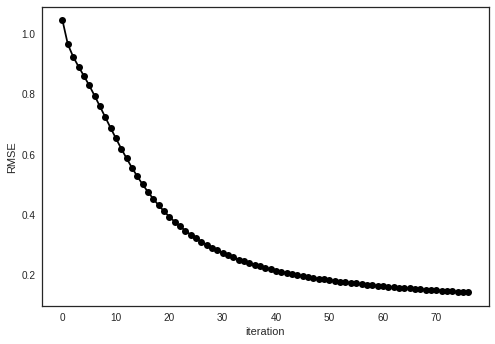

In [22]:
#conv_curve = rec.steps[1][1].get_convergence_curve()
conv_curve = rec.named_steps['lf_recommender'].get_convergence_curve()
iter_index,rmse = tuple(zip(*conv_curve))

plt.plot(iter_index,rmse, '-ok')
plt.xlabel('iteration')
plt.ylabel('RMSE')

## RMSE on test set
Next, we calculate the root mean square error (RMSE) on our test set.

In [23]:
"""ratings_extractor = RatingsExtractor()
test_ratings_matrix = ratings_extractor.transform(df_test)
row_col_indices = ratings_extractor.get_row_col_indices(df_test)
test_ratings = [test_ratings_matrix[r,c] for r,c in row_col_indices]

pred = rec.named_steps['lf_recommender'].predict(row_col_indices)

rmse = np.sqrt(mean_squared_error(test_ratings, pred))
print (rmse)"""

"ratings_extractor = RatingsExtractor()\ntest_ratings_matrix = ratings_extractor.transform(df_test)\nrow_col_indices = ratings_extractor.get_row_col_indices(df_test)\ntest_ratings = [test_ratings_matrix[r,c] for r,c in row_col_indices]\n\npred = rec.named_steps['lf_recommender'].predict(row_col_indices)\n\nrmse = np.sqrt(mean_squared_error(test_ratings, pred))\nprint (rmse)"

In [24]:
test_ratings = df_test['rating'].values
itemid_userid_array = [tuple(x) for x in df_test[['itemId', 'userId']]
                       .to_records(index=False)]

In [25]:
rec_pipeline.named_steps

{'lf_recommender': LatentFactorRecSys(learning_rate=0.001, max_iter=10, num_factors=20,
           reg_item_bias=0.1, reg_item_fact=0.1, reg_user_bias=0.1,
           reg_user_fact=0.1, tolerance=0.01),
 'ratings_extractor': RatingsExtractor()}

In [26]:
lf_recommender = rec.named_steps['lf_recommender']
ratings_extractor = rec.named_steps['ratings_extractor']
#ratings_extractor = RatingsExtractor()
#ratings_extractor.transform(df_ratings)
pred = lf_recommender.predict(itemid_userid_array, ratings_extractor)
rmse = np.sqrt(mean_squared_error(test_ratings, pred))
print (rmse)

0.968712576811


The **RMSE of 0.97** looks pretty good, given that we didn't perform exhaustive search for the best model parameters.

In [310]:
# Save trained model
with open('lf_movie_recommender.pkl', 'wb') as handle:
    pickle.dump(rec, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load trained model
#with open('lf_movie_recommender.pkl', 'rb') as handle:
#    rec = pickle.load(handle)    

## Compute Recommendations

### Helper functions: Filter similar movies based on cosine distance as a similarity metric

In [59]:
def cosine_similarity(item_factors):
    cos_sim = np.matmul(item_factors, item_factors.transpose())
    norm = np.diagonal(cos_sim)
    norm_mat = np.sqrt(np.outer(norm, norm))
    cos_sim = np.divide(cos_sim, norm_mat)
    return cos_sim

def cosine_distance(item_factors):
    return 1 - cosine_similarity(item_factors)

cos_dist = cosine_distance(lf_recommender.Q)

array([[ 0.  ,  0.9 ,  0.89, ...,  0.71,  0.69,  0.83],
       [ 0.9 ,  0.  ,  1.09, ...,  1.  ,  0.89,  0.99],
       [ 0.89,  1.09,  0.  , ...,  0.92,  0.82,  0.89],
       ..., 
       [ 0.71,  1.  ,  0.92, ...,  0.  ,  0.46,  0.36],
       [ 0.69,  0.89,  0.82, ...,  0.46,  0.  ,  0.31],
       [ 0.83,  0.99,  0.89, ...,  0.36,  0.31,  0.  ]])

In [199]:
def get_movie_name(df_movies, itemid):
    movie_name = df_movies[df_movies['movieId']==itemid]['title'].values[0]
    return movie_name


def get_similar_items(itemid, num_recs):
    itemindex = ratings_extractor.item2index_dict[itemid]
    dists = cos_dist[itemindex,:]
    indices = dists.argsort()[1:num_recs+1]

    similar_item_ids = [ratings_extractor.index2item_dict[i] for i in indices]
        
    similar_item_names = []
    for itemid in similar_item_ids:
        similar_item_names.append(get_movie_name(df_movies, itemid))
        
    return similar_item_names
        
    
"""num_recs = 5       
itemid = 1
movie_name = get_movie_name(df_movies, itemid)
print ('%s ==>' %movie_name)
get_similar_items(itemid, num_recs)"""

"num_recs = 5       \nitemid = 1\nmovie_name = get_movie_name(df_movies, itemid)\nprint ('%s ==>' %movie_name)\nget_similar_items(itemid, num_recs)"

### Helper functions: Retrieve IMDB ID given a movie title
IMDB ID is used to get movie poster from [themoviedb.org API](!https://www.themoviedb.org/documentation/api).

In [245]:
def strip_year(movie_name):
    movie_name = re.sub(r'\([^)]*\)', '', movie_name).strip()

    return movie_name


def imdb_id_from_title(title):
    title = strip_year(title)
    
    pattern = 'http://www.imdb.com/xml/find?json=1&nr=1&tt=on&q={movie_title}'
    url = pattern.format(movie_title=urllib.parse.quote_plus(title))
    r = requests.get(url)
    res = r.json()
    # sections in descending order or preference
    for section in ['popular','exact','substring']:
        key = 'title_' + section 
        if key in res:
            return res[key][0]['id']
        
        
"""strip_year('Toy Story (1995)')"""
"""imdb_id_from_title('Toy Story (1995)')"""

'Toy Story'

### Helper functions: Display movie posters

In [261]:
CONFIG_PATTERN = 'http://api.themoviedb.org/3/configuration?api_key={key}'
KEY = 'cd3fbcc9cb70affd9a68b0951b3d0997'

In [262]:
def size_str_to_int(x):
    return float("inf") if x == 'original' else int(x[1:])

In [263]:
url = CONFIG_PATTERN.format(key=KEY)
r = requests.get(url)
config = r.json()

base_url = config['images']['base_url']
sizes = config['images']['poster_sizes']
max_size = max(sizes, key=size_str_to_int)

In [291]:
def get_poster_url(movie_name):
    imdb_id = imdb_id_from_title(movie_name)

    IMG_PATTERN = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={key}' 
    r = requests.get(IMG_PATTERN.format(key=KEY,imdbid=imdb_id))
    api_response = r.json()
    
    poster = api_response['posters'][0] # Get the best rated poster
    rel_path = poster['file_path']
    poster_url = "{0}{1}{2}".format(base_url, max_size, rel_path)
    return poster_url


"""movie_name = 'Toy Story'    
get_poster(movie_name)"""

"movie_name = 'Toy Story'    \nget_poster(movie_name)"

## Display Recommendations

In [303]:
# see https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell
def make_html(image_url):
    return "<img style='width: 120px; margin: 0px; float: left; \
    border: 1px solid black;' src='%s' />" % image_url


def display_rec_movies(movieid, num_recs):
    movie_name = get_movie_name(df_movies, movieid)
    poster_url = get_poster_url(movie_name)
    
    print ('Input movie:')
    display(HTML(make_html(poster_url)))
    
    recommended_item_names = get_similar_items(movieid, num_recs)
    
    print ('Recommended movies: ')
    imagesList = ''
    for movie_name in recommended_item_names:
        poster_url = get_poster_url(movie_name)
        imagesList += make_html(poster_url)
    display(HTML(imagesList))

    
"""movieid = 1
display_rec_movies(movieid)"""

'movieid = 1\ndisplay_rec_movies(movieid)'

In [304]:
movieids = [1, 10, 50]
num_recs = 5       

for movieid in movieids:
    display_rec_movies(movieid, num_recs)
    print ('\n\n')

Input movie:


Recommended movies: 





Input movie:


Recommended movies: 





Input movie:


Recommended movies: 
